This notebook will be collected automatically at **6pm on Monday** from `/home/data_scientist/assignments/Week6` directory on the course JupyterHub server. If you work on this assignment on the course Jupyterhub server, just make sure that you save your work and instructors will pull your notebooks automatically after the deadline. If you work on this assignment locally, the only way to submit assignments is via Jupyterhub, and you have to place the notebook file in the correct directory with the correct file name before the deadline.

1. Make sure everything runs as expected. First, restart the kernel (in the menubar, select `Kernel` → `Restart`) and then run all cells (in the menubar, select `Cell` → `Run All`).
2. Make sure you fill in any place that says `YOUR CODE HERE`. Do not write your answer in anywhere else other than where it says `YOUR CODE HERE`. Anything you write anywhere else will be removed by the autograder.
3. Do not change the file path or the file name of this notebook.
4. Make sure that you save your work (in the menubar, select `File` → `Save and CheckPoint`)

# Problem 6.2. Practical Concepts.

In this problem, we explore a number of practical concepts that can be very important in real-world machine learning applications. These concepts include

- Feature Scaling
- Feature Selection
- Pipelining
- Cross Validation
- Grid Search
- Validation/Learning Curves

We have already encounted some of these concepts in the previous assignments. For example, we explored cross validation in [Problem 4.2]( https://github.com/UI-DataScience/info490-sp16/blob/master/Week4/assignments/w4p2.ipynb) and feature scaling in [Problem 5.1](https://github.com/UI-DataScience/info490-sp16-private/blob/master/Week5/assignment/w5p1.ipynb), so we won't repeat those concepts in this problem.

In [1]:
% matplotlib inline

import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn import preprocessing
from sklearn import svm
from sklearn import cross_validation as cv
from sklearn.feature_selection import RFE, SelectKBest, f_regression
from sklearn.metrics import accuracy_score
from sklearn.utils import check_random_state
from sklearn.pipeline import Pipeline
from sklearn.grid_search import GridSearchCV
from sklearn.learning_curve import validation_curve

from nose.tools import assert_equal, assert_is_instance, assert_is_not
from numpy.testing import assert_array_equal, assert_array_almost_equal, assert_almost_equal

You can find the descriptions of the columns [here](http://stat-computing.org/dataexpo/2009/the-data.html).

In [2]:
df = pd.read_csv(
    '/home/data_scientist/data/2001.csv',
    encoding='latin-1',
    usecols=(1, 2, 3, 5, 7, 13, 15, 16, 18)
    )

For simplicity, we use only 1% percent of flights that departed from ORD. We also convert the `DepDelay` variables to a binary indicator, which we try to predict from the remaining attributes.

In [3]:
local = df[df['Origin'] == 'ORD'].drop('Origin', axis=1) # we don't need the Origin column anymore.
local = local.dropna().reset_index(drop=True)

# 1 if a flight was delayed, 0 if not.
y = pd.DataFrame((local['DepDelay'] > 0).astype(np.int), columns=['DepDelay'])
local = local.drop('DepDelay', axis=1)

np.random.seed(0)
idx = np.random.choice(len(local), len(local) / 100)
X = local.loc[idx, :]
y = y.loc[idx, :]

del df # we don't need this big data frame anymore

/opt/conda/lib/python3.5/site-packages/ipykernel/__main__.py:9: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


## Feature Scaling

In [4]:
X = pd.DataFrame(preprocessing.StandardScaler().fit_transform(X), columns=X.columns)
print(X.head())

      Month  DayofMonth  DayOfWeek  CRSDepTime  CRSArrTime   AirTime  Distance
0  1.649049    0.837020   1.529541   -0.731371   -0.699318 -0.842368 -0.881512
1 -0.388869    1.062662   0.526987    0.995111    1.110583 -0.085181 -0.217950
2 -0.097738   -0.516829  -1.478120    0.115162    0.265822 -0.352423 -0.336576
3  1.649049    1.288304   0.025710    1.663427    1.564642  1.844903  1.759760
4 -0.388869   -0.065546  -0.976843    1.284715    1.389354 -0.411811 -0.306919


## Feature Selection

- Use [Recursive Feature Elimination](http://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.RFE.html) to determine the most important features 

In [8]:
def select_features(X, y, random_state, kernel='linear', C=1.0, num_attributes=3):
    '''
    Uses Support Vector Classifier as the estimator to rank features
    with Recursive Feature Eliminatin.
    
    Parameters
    ----------
    X: A pandas.DataFrame. Attributes.
    y: A pandas.DataFrame. Labels.
    random_state: A RandomState instance. Used in SVC().
    kernel: A string. Used in SVC(). Default: "linear".
    C: A float. Used in SVC(). Default: 1.0.
    num_attributes: An int. The number of features to select in RFE. Default: 3.
    
    Returns
    -------
    A 3-tuple of (RFE, np.ndarray, np.ndarray)
    model: An RFE instance.
    columns: Selected features.
    ranking: The feature ranking. Selected features are assigned rank 1.
    '''
    
    # YOUR CODE HERE
    svc = svm.SVC(kernel=kernel, C=C, random_state=random_state)
    model = RFE(svc, num_attributes)
    model = model.fit(X, y)
    columns = X.columns[model.support_]
    ranking = model.ranking_
            
    return model, columns, ranking

In [9]:
rfe, rfe_columns, rfe_ranking = select_features(X, y, check_random_state(0))

/opt/conda/lib/python3.5/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [10]:
assert_is_instance(rfe, RFE)
assert_is_instance(rfe_ranking, np.ndarray)

assert_is_instance(rfe.estimator, svm.SVC)
assert_equal(rfe.estimator.kernel, 'linear')
assert_equal(rfe.estimator.C, 1)
assert_equal(rfe.n_features_, 3)

assert_array_equal(rfe_columns, ['CRSDepTime', 'AirTime', 'Distance'])
assert_array_equal(rfe_ranking, [3, 5, 2, 1, 4, 1, 1])

## Pipeline

- Construct a pipeline to employ to select the k best features from a data set along with an SVC classification.

Select top 3 features, and use [ANOVA F-value](http://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.f_classif.html#sklearn.feature_selection.f_classif) for the score function. Name the pipe elements "anova" and "svc".

In [14]:
def pipeline_anova_svm(X, y, random_state, k=3, kernel='linear'):
    '''
    Selects top k=3 features with a pipeline that uses ANOVA F-value
    and a Support Vector Classifier.
    
    Parameters
    ----------
    X: A pandas.DataFrame. Attributes.
    y: A pandas.DataFrame. Labels.
    random_state: A RandomState instance. Used in SVC().
    k: An int. The number of features to select. Default: 3
    kernel: A string. Used by SVC(). Default: 'linear'
    
    Returns
    -------
    A 2-tuple of (Pipeline, np.ndarray)
    model: An ANOVA SVM-C pipeline.
    predictions: Classifications predicted by the pipeline.
    '''
    
    # YOUR CODE HERE
    
    anova = SelectKBest(f_regression, k=k)
    svc = svm.SVC(kernel=kernel)

    # Create a pipeline, with names for pipe elements
    model = Pipeline([('anova', anova), ('svc', svc)])

    # You can set the parameters using the names
    model.set_params(anova__k=k).fit(X, y)
    predictions = model.predict(X)
    
    return model, predictions

In [15]:
anova_svm, y_pred = pipeline_anova_svm(X, y, random_state=check_random_state(0))

/opt/conda/lib/python3.5/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.5/site-packages/sklearn/svm/base.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y_ = column_or_1d(y, warn=True)


In [16]:
assert_is_instance(anova_svm, Pipeline)
assert_equal(anova_svm.steps[0][0], 'anova')
assert_equal(anova_svm.steps[1][0], 'svc')
assert_equal(anova_svm.get_params()['anova__k'], 3)
assert_equal(anova_svm.get_params()['svc__kernel'], 'linear')
assert_equal(anova_svm.get_params()['svc__C'], 1.0)

assert_is_instance(y_pred, np.ndarray)
assert_equal(len(y_pred), len(y))
assert_array_equal(y_pred[:10], [0, 1, 0, 1, 1, 1, 0, 0, 0, 1])
assert_array_equal(y_pred[-10:], [0, 0, 1, 0, 0, 0, 0, 0, 0, 0])

## Grid Search

- Use a [GridSearchCV](http://scikit-learn.org/stable/modules/generated/sklearn.grid_search.GridSearchCV.html) object to compute the best value for the C parameter when running the SVC algorithm.

In [26]:
def grid_search_c(X, y, split_rs, svc_rs, c_vals, test_size=0.2, kernel='linear'):
    '''
    
    Parameters
    ----------
    X: A pandas.DataFrame. Attributes.
    y: A pandas.DataFrame. Labels.
    split_rs: A RandomState instance. Used in train_test_split().
    svc_rs: A RandomState instance. Used in SVC().
    c_vals: A np.array. A list of parameter settings to try as vlues.
    test_size: A float. Used in train_test_split(). Default: 0.2
    kernel: A string. Used by SVC(). Default: 'linear'

    Returns
    -------
    A 3-tuple of (GridSearchCV, float, float)
    model: A GridSearchCV instance.
    best_C: The value of C that gave the highest score.
    best_cv_score: Score of best_C on the hold out data.
    '''
    
    # YOUR CODE HERE
    y = np.ravel(y)   # used to fix too many indices error
    (X_trn, X_tst, y_trn, y_tst) = cv.train_test_split(X, y, test_size=test_size, random_state=split_rs)
    svc = svm.SVC(random_state=svc_rs, kernel=kernel)
    model = GridSearchCV(estimator=svc, param_grid=dict(C=c_vals))
    model.fit(X_trn, y_trn)
    best_C = model.best_estimator_.C
    best_cv_score = model.best_score_

    return model, best_C, best_cv_score

In [27]:
clf, best_C, best_cv_score = grid_search_c(
    X, y,
    split_rs=check_random_state(0),
    svc_rs=check_random_state(0),
    c_vals=np.logspace(-5, 2, 20)
    )

In [28]:
assert_is_instance(clf, GridSearchCV)
assert_is_instance(clf.estimator, svm.SVC)
assert_equal(clf.estimator.C, 1.0)
assert_equal(clf.estimator.kernel, 'linear')
assert_array_equal(clf.param_grid['C'], np.logspace(-5, 2, 20))

assert_almost_equal(best_C, 0.0088586679041008226)
assert_almost_equal(best_cv_score, 0.57248348231636226)

## Validation Curves

- Compute and display the validation curve for SVM-C.

Vary the $\gamma$ parameter for the values in `param_range`. Since `param_range` is on a log scale, the x-axis of your plot should also be on a log scale. Use a 5-fold cross validation. Plot the mean accuracy score for the training set first, and then plot the mean accuracy score for the cross validation data.

![](https://raw.githubusercontent.com/UI-DataScience/info490-sp16/master/Week6/assignments/images/valid_curve.png)

Note the computation of the data for these curves can take a while.

In [50]:
def plot_validation_curve(X, y, param_range):
    '''
    Computes and displays the validation curve for SVC.
    
    Parameters
    ----------
    X: A pandas.DataFrame. Attributes.
    y: A pandas.DataFrame. Labels.
    param_range: The values of the parameter that will be evaluated.
    
    Returns
    -------
    A maplotlib.Axes instance.
    '''
    
    # YOUR CODE HERE
    y = np.ravel(y)
    trn_scr, tst_scr = validation_curve(svm.SVC(random_state=check_random_state(0)), X, y, param_name="gamma", \
                                    param_range=param_range, cv=5, scoring="accuracy")
    y1 = np.mean(trn_scr, axis=1)
    y2 = np.mean(tst_scr, axis=1)
    fig, ax = plt.subplots()
    
    ax.semilogx(param_range, y1, label="Training Score", marker='d', lw=2, color='b')
    ax.semilogx(param_range, y2, label="CV Score", marker='d', lw=2, color='g')
    ax.set_xlabel('$\gamma$', fontsize=18)
    ax.set_ylabel('Score', fontsize=18)
    ax.set_title('Validation Curve with SVM', fontsize=18)
    ax.legend(loc='best', fontsize=18)
    
    return ax

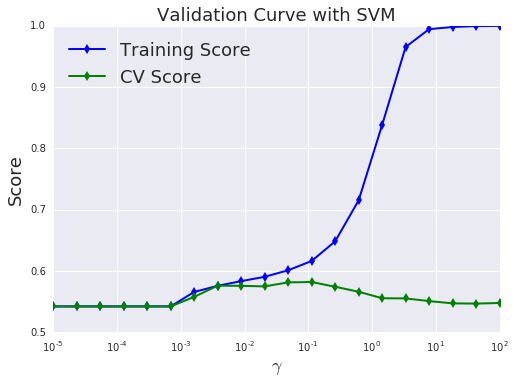

In [51]:
param_range = np.logspace(-5, 2, 20)
ax_vl = plot_validation_curve(X, y, param_range=param_range)

In [52]:
assert_is_instance(ax_vl, mpl.axes.Axes)

x_train, y_train = ax_vl.lines[0].get_xydata().T
assert_array_almost_equal(x_train, param_range)
assert_array_almost_equal(y_train,
    [0.54243086, 0.54243086, 0.54243086, 0.54243086, 0.54243086,
     0.54243086, 0.56605497, 0.57600251, 0.58361821, 0.59068994,
     0.60133712, 0.61648984, 0.64842962, 0.71518516, 0.83804752,
     0.96510729, 0.99417159, 0.9976687 , 0.99914521, 0.99945604]
    )

x_valid, y_valid = ax_vl.lines[1].get_xydata().T
assert_array_almost_equal(x_valid, param_range)
assert_array_almost_equal(y_valid,
    [0.54243115, 0.54243115, 0.54243115, 0.54243115, 0.54243115,
     0.54243115, 0.55796924, 0.57630816, 0.57600243, 0.57507124,
     0.58160071, 0.58221941, 0.57444867, 0.56636448, 0.55579968,
     0.55548719, 0.55113646, 0.54740541, 0.54709292, 0.54802604]
    )

assert_is_not(len(ax_vl.title.get_text()), 0,
    msg="Your plot doesn't have a title.")
assert_is_not(ax_vl.xaxis.get_label_text(), '',
    msg="Change the x-axis label to something more descriptive.")
assert_is_not(ax_vl.yaxis.get_label_text(), '',
    msg="Change the y-axis label to something more descriptive.")